In [48]:
# pip install torch quantities sparse==0.11.0 > /dev/null

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection, utils
import torch
import quantities as units
from sparse import COO
%matplotlib inline

## Problème 5

### Paramètre

- Subsitution du gradient : Fonction de ReLu avec $\alpha = 0.01$
- Nombre de couches : 2
- Nombre de neurones : 128
- Nombre d’iterations : 4
- Taux d’apprentissage : 0.01
- Pas de discretisation $\left(\Delta T\right)$ : 10 ms
- **Taille des lots : 512**

In [49]:
nb_neurons = np.arange(128, 257, step=32)
nb_iteration = 6
learning_rate = np.arange(0.01, 0.15, step=0.03)
discretisation = np.arange(1, 14, step=3)
lot_size = np.arange(256, 513, step=64)

#### Packages et imports

#### Configuration

In [50]:
# Reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Use the GPU unless there is none available.
# If you don't have a CUDA enabled GPU, I recommned using Google Colab,
# available at https://colab.research.google.com. Create a new notebook
# and then go to Runtime -> Change runtime type -> Hardware accelerator -> GPU
# Colab gives you access to up to 12 free continuous hours of a fairly recent GPU.
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


#### Préparation des données

In [51]:
# Let's download the MNIST dataset, available at https://www.openml.org/d/554
# You can edit the argument data_home to the directory of your choice.
# The dataset will be downloaded there; the default directory is ~/scikit_learn_data/
X, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True, data_home=None, as_frame=False)
nb_of_samples, nb_of_features = X.shape
# X = 70k samples, 28*28 features; y = 70k samples, 1 label (string)

# Shuffle the dataset
X, y = utils.shuffle(X, y)

# Convert the labels (string) to integers for convenience
y = np.array(y, dtype=int)
nb_of_ouputs = np.max(y) + 1

# We'll normalize our input data in the range [0, 1[.
X = X / pow(2, 8)

/home/archfox/Sources/GEI723_APP3/venv/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


#### Conversion en décharges

#### Split entrainement/test

In [52]:
# Split in train/test
nb_of_train_samples = int(nb_of_samples * 0.85)  # Keep 15% of the dataset for testing
train_indices = np.arange(nb_of_train_samples)
test_indices = np.arange(nb_of_train_samples, nb_of_samples)

In [53]:
"""
Cette class permet de calculer la sortie d'une fonction lors de la propagation avant et de personaliser la derivée lors de la retropropagation de l'erreur.
Voir cet exemple pour plus de détails : https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html
"""
class SpikeFunction(torch.autograd.Function):
    """
    Dans la passe avant, nous recevons un tenseur contenant l'entrée (potential-threshold).
    Nous appliquons la fonction Heaviside et renvoyons un tenseur contenant la sortie.
    """
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0 # On génère une décharge quand (potential-threshold) > 0
        return out

    """
    Dans la passe arrière, nous recevons un tenseur contenant le gradient de l'erreur par rapport à la sortie.
    Nous calculons le gradient de l'erreur par rapport à l'entrée en utilisant la dérivée de la fonction ReLu.
    """
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_relu = torch.ones_like(input) # The derivativen ReLU function
        grad_relu[input < 0] = 0.01        # Apply alpha = 0.01 to negative input
        return grad_output.clone()*grad_relu

In [54]:
def run_spiking_layer(input_spike_train, layer_weights, tau_v=20*units.ms, tau_i=5*units.ms, v_threshold=1.0):
    global dt
    """Here we implement a current-LIF dynamic in PyTorch"""

    # First, we multiply the input spike train by the weights of the current layer to get the current that will be added
    # We can calculate this beforehand because the weights are constant in the forward pass (no plasticity)
    input_current = torch.einsum("abc,bd->adc", (input_spike_train, layer_weights))  # Equivalent to a matrix multiplication for tensors of dim > 2 using Einstein's Notation

    recorded_spikes = []  # Array of the output spikes at each time t
    membrane_potential_at_t = torch.zeros((input_spike_train.shape[0], layer_weights.shape[-1]), device=device, dtype=torch.float)
    membrane_current_at_t = torch.zeros((input_spike_train.shape[0], layer_weights.shape[-1]), device=device, dtype=torch.float)

    const_a = dt / tau_i
    alpha = np.exp(-(const_a.item()))

    const_b = dt / tau_v
    beta = np.exp(-(const_b.item()))

    for t in range(absolute_duration):  # For every timestep
        # Apply the leak
        membrane_potential_at_t = torch.mul(membrane_potential_at_t, beta) # Using tau_v with euler or exact method
        membrane_current_at_t = torch.mul(membrane_current_at_t, alpha) # Using tau_i with euler or exact method

        # Select the input current at time t
        input_at_t = input_current[:, :, t]

        # Integrate the input current
        membrane_current_at_t += input_at_t

        # Integrate the input to the membrane potential
        membrane_potential_at_t += membrane_current_at_t

        # Apply the non-differentiable function
        recorded_spikes_at_t = SpikeFunction.apply(membrane_potential_at_t - v_threshold)
        recorded_spikes.append(recorded_spikes_at_t)

        # Reset the spiked neurons
        membrane_potential_at_t[membrane_potential_at_t > v_threshold] = 0

    recorded_spikes = torch.stack(recorded_spikes, dim=2) # Stack over time axis (Array -> Tensor)
    return recorded_spikes


#### Entrainement

In [55]:
def train():
    global train_indices, number_of_batches, nb_of_epochs, optimizer, loss
    losses = np.zeros((nb_of_epochs))
    for e in range(nb_of_epochs):
        i = 0
        for batch in np.array_split(train_indices, number_of_batches):
            i += 1
            # Select batch and convert to tensors
            batch_spike_train = torch.FloatTensor(spike_train[batch].todense()).to(device)
            batch_labels = torch.LongTensor(y[batch, np.newaxis]).to(device)

            # Here we create a target spike count (10 spikes for wrong label, 100 spikes for true label) in a one-hot fashion
            # This approach is seen in Shrestha & Orchard (2018) https://arxiv.org/pdf/1810.08646.pdf
            # Code available at https://github.com/bamsumit/slayerPytorch
            min_spike_count = 10 * torch.ones((batch.shape[0], 10), device=device, dtype=torch.float)
            target_output = min_spike_count.scatter_(1, batch_labels, 100.0)

            # Forward propagation
            layer_1_spikes = run_spiking_layer(batch_spike_train, w1)
            layer_2_spikes = run_spiking_layer(layer_1_spikes, w2)
            network_output = torch.sum(layer_2_spikes, 2)  # Count the spikes over time axis
            loss = loss_fn(network_output, target_output)

            # Backward propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses[e] += loss.item()

            print("Batch %i out of %i in Epoch %i -- loss : %.4f" %(i, number_of_batches, e+1, loss.item()))
        
        print("Epoch %i -- loss : %.4f" %(e+1, losses[e] / number_of_batches))
        losses[e] /= number_of_batches
    return losses

# Test

In [56]:
# Test the accuracy of the model
def test():
    correct_label_count = 0

    # We only need to batchify the test set for memory requirements
    for batch in np.array_split(test_indices,  len(test_indices) // batch_size):
        test_spike_train = torch.FloatTensor(spike_train[batch].todense()).to(device)

        # Same forward propagation as before
        layer_1_spikes = run_spiking_layer(test_spike_train, w1)
        layer_2_spikes = run_spiking_layer(layer_1_spikes, w2)
        network_output = torch.sum(layer_2_spikes, 2)  # Count the spikes over time axis

        # Do the prediction by selecting the output neuron with the most number of spikes
        _, am = torch.max(network_output, 1)
        correct_label_count += np.sum(am.detach().cpu().numpy() == y[batch])

    print("Model accuracy on test set: %.3f" % (correct_label_count / len(test_indices)))
    return correct_label_count / len(test_indices)

#### Création du réseau

In [75]:
def reset():
    global number_of_batches, w1, w2, params, optimizer, loss_fn, absolute_duration, spike_train, dt, batch_size, nb_hidden, lr, nb_of_epochs

    number_of_batches = 0
    # Set-up training
    batch_size = lot_size[0]  # The backpropagation is done after every batch, but a batch here is also used for memory requirements
    nb_hidden = nb_neurons[0]  # Number of hidden neurons
    lr = learning_rate[0]
    nb_of_epochs = nb_iteration
    dt = discretisation[0]*units.ms

    number_of_batches = len(train_indices) // batch_size
    w1 = torch.empty((nb_of_features, nb_hidden), device=device, dtype=torch.float, requires_grad=True)
    torch.nn.init.normal_(w1, mean=0., std=.1)

    w2 = torch.empty((nb_hidden, nb_of_ouputs), device=device, dtype=torch.float, requires_grad=True)
    torch.nn.init.normal_(w2, mean=0., std=.1)

    params = [w1, w2]  # Trainable parameters
    
    optimizer = torch.optim.Adam(params, lr=lr, amsgrad=True)
    loss_fn = torch.nn.MSELoss(reduction='mean')

    # And convert the data to a spike train using TTFS encoding
    duration_per_image = 100*units.ms
    absolute_duration = int(duration_per_image / dt)

    time_of_spike = (1 - X) * absolute_duration  # The brighter the pixel, the earlier the spike
    time_of_spike[X < .25] = 0  # "Remove" the spikes associated with darker pixels, which presumably carry less information

    sample_id, neuron_idx = np.nonzero(time_of_spike)

    # We use a sparse COO array to store the spikes for memory requirements
    # You can use the spike_train variable as if it were a tensor of shape (nb_of_samples, nb_of_features, absolute_duration)
    spike_train = COO((sample_id, neuron_idx, time_of_spike[sample_id, neuron_idx]),
                        np.ones_like(sample_id), shape=(nb_of_samples, nb_of_features, absolute_duration))



# Varier Learning Rate

In [58]:
losses = []
accuracies = []
for l in learning_rate:
    global lr
    lr = l
    reset()
    losses.append(train())
    accuracies.append(test())


Batch 1 out of 232 in Epoch 1 -- loss : 871.4377
Batch 2 out of 232 in Epoch 1 -- loss : 976.1160
Batch 3 out of 232 in Epoch 1 -- loss : 619.7615
Batch 4 out of 232 in Epoch 1 -- loss : 582.9638
Batch 5 out of 232 in Epoch 1 -- loss : 560.2759
Batch 6 out of 232 in Epoch 1 -- loss : 505.4047
Batch 7 out of 232 in Epoch 1 -- loss : 497.4027
Batch 8 out of 232 in Epoch 1 -- loss : 482.5681
Batch 9 out of 232 in Epoch 1 -- loss : 452.5432
Batch 10 out of 232 in Epoch 1 -- loss : 452.9132
Batch 11 out of 232 in Epoch 1 -- loss : 474.9957
Batch 12 out of 232 in Epoch 1 -- loss : 476.7428
Batch 13 out of 232 in Epoch 1 -- loss : 485.7595
Batch 14 out of 232 in Epoch 1 -- loss : 417.7856
Batch 15 out of 232 in Epoch 1 -- loss : 427.2448
Batch 16 out of 232 in Epoch 1 -- loss : 428.3401
Batch 17 out of 232 in Epoch 1 -- loss : 374.5759
Batch 18 out of 232 in Epoch 1 -- loss : 428.1654
Batch 19 out of 232 in Epoch 1 -- loss : 370.8315
Batch 20 out of 232 in Epoch 1 -- loss : 362.6525
Batch 21 

<Figure size 800x500 with 0 Axes>

## Générer graphique

In [ ]:
plt.figure(figsize=(8,5))
plt.title("Varying Learning Rate")
for i, l in enumerate(losses):
    plt.plot(l, label="lr=%.2f, Accuracy=%.3f"%(learning_rate[i], accuracies[i]))
plt.legend()

# Varier Batch Size

In [71]:
losses = []
accuracies = []
for b in lot_size:
    global batch_size
    batch_size = b
    reset()
    losses.append(train())
    accuracies.append(test())

Batch 1 out of 232 in Epoch 1 -- loss : 888.6732
Batch 2 out of 232 in Epoch 1 -- loss : 5899.1138
Batch 3 out of 232 in Epoch 1 -- loss : 1711.1012
Batch 4 out of 232 in Epoch 1 -- loss : 1090.0000
Batch 5 out of 232 in Epoch 1 -- loss : 1090.0000
Batch 6 out of 232 in Epoch 1 -- loss : 1090.0000
Batch 7 out of 232 in Epoch 1 -- loss : 1090.0000
Batch 8 out of 232 in Epoch 1 -- loss : 1090.0000
Batch 9 out of 232 in Epoch 1 -- loss : 1090.0000
Batch 10 out of 232 in Epoch 1 -- loss : 1090.0000
Batch 11 out of 232 in Epoch 1 -- loss : 1090.0000
Batch 12 out of 232 in Epoch 1 -- loss : 1090.0000
Batch 13 out of 232 in Epoch 1 -- loss : 1089.0533
Batch 14 out of 232 in Epoch 1 -- loss : 1090.0000
Batch 15 out of 232 in Epoch 1 -- loss : 1090.0000
Batch 16 out of 232 in Epoch 1 -- loss : 1089.3035
Batch 17 out of 232 in Epoch 1 -- loss : 1089.1035
Batch 18 out of 232 in Epoch 1 -- loss : 1086.6176
Batch 19 out of 232 in Epoch 1 -- loss : 1086.8785
Batch 20 out of 232 in Epoch 1 -- loss : 

## Générer graphique

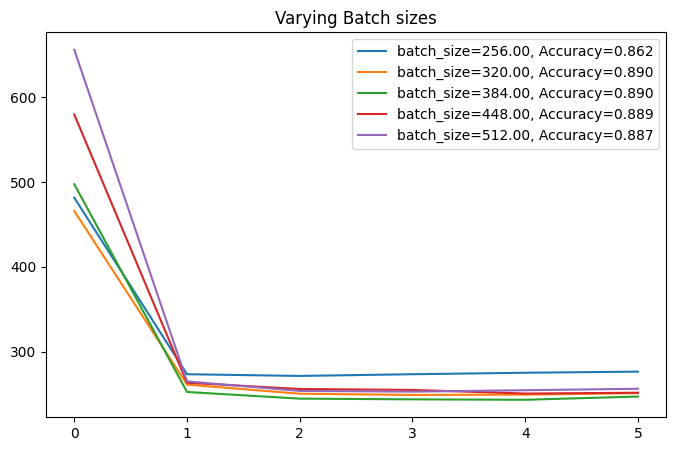

In [72]:
plt.figure(figsize=(8,5))
plt.title("Varying Batch sizes")
for i, l in enumerate(losses):
    plt.plot(l, label="batch_size=%.2f, Accuracy=%.3f"%(lot_size[i], accuracies[i]))
plt.legend()

# Varier Nombre de Neurones

In [76]:
losses = []
accuracies = []
for nb in nb_neurons:
    global nb_hidden
    nb_hidden = nb
    reset()
    losses.append(train())
    accuracies.append(test())

Batch 1 out of 232 in Epoch 1 -- loss : 907.9848
Batch 2 out of 232 in Epoch 1 -- loss : 952.7027
Batch 3 out of 232 in Epoch 1 -- loss : 695.7977
Batch 4 out of 232 in Epoch 1 -- loss : 633.6926
Batch 5 out of 232 in Epoch 1 -- loss : 571.9685
Batch 6 out of 232 in Epoch 1 -- loss : 542.0899
Batch 7 out of 232 in Epoch 1 -- loss : 519.5813
Batch 8 out of 232 in Epoch 1 -- loss : 514.7222
Batch 9 out of 232 in Epoch 1 -- loss : 465.9416
Batch 10 out of 232 in Epoch 1 -- loss : 470.6704
Batch 11 out of 232 in Epoch 1 -- loss : 470.2210
Batch 12 out of 232 in Epoch 1 -- loss : 466.2802
Batch 13 out of 232 in Epoch 1 -- loss : 472.4708
Batch 14 out of 232 in Epoch 1 -- loss : 422.2798
Batch 15 out of 232 in Epoch 1 -- loss : 413.7988
Batch 16 out of 232 in Epoch 1 -- loss : 425.7875
Batch 17 out of 232 in Epoch 1 -- loss : 378.8607
Batch 18 out of 232 in Epoch 1 -- loss : 443.3513
Batch 19 out of 232 in Epoch 1 -- loss : 393.1234
Batch 20 out of 232 in Epoch 1 -- loss : 389.3914
Batch 21 

## Générer graphique

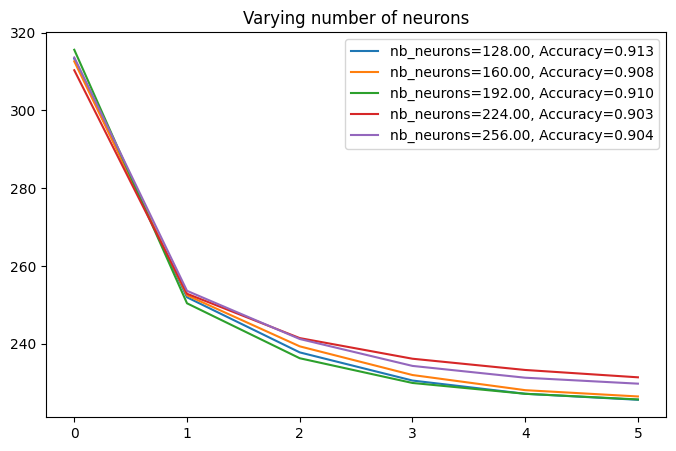

In [77]:
plt.figure(figsize=(8,5))
plt.title("Varying number of neurons")
for i, l in enumerate(losses):
    plt.plot(l, label="nb_neurons=%.2f, Accuracy=%.3f"%(nb_neurons[i], accuracies[i]))
plt.legend()

# Varier Discretisations

In [78]:
losses = []
accuracies = []
for d in discretisation:
    global dt
    dt = d*units.ms
    reset()
    losses.append(train())
    accuracies.append(test())

Batch 1 out of 232 in Epoch 1 -- loss : 929.0557
Batch 2 out of 232 in Epoch 1 -- loss : 968.9599
Batch 3 out of 232 in Epoch 1 -- loss : 663.4771
Batch 4 out of 232 in Epoch 1 -- loss : 632.3564
Batch 5 out of 232 in Epoch 1 -- loss : 565.3619
Batch 6 out of 232 in Epoch 1 -- loss : 566.0712
Batch 7 out of 232 in Epoch 1 -- loss : 541.1121
Batch 8 out of 232 in Epoch 1 -- loss : 523.6160
Batch 9 out of 232 in Epoch 1 -- loss : 474.6342
Batch 10 out of 232 in Epoch 1 -- loss : 480.7401
Batch 11 out of 232 in Epoch 1 -- loss : 468.6272
Batch 12 out of 232 in Epoch 1 -- loss : 462.5844
Batch 13 out of 232 in Epoch 1 -- loss : 473.7389
Batch 14 out of 232 in Epoch 1 -- loss : 438.2374
Batch 15 out of 232 in Epoch 1 -- loss : 435.2261
Batch 16 out of 232 in Epoch 1 -- loss : 432.9673
Batch 17 out of 232 in Epoch 1 -- loss : 389.3039
Batch 18 out of 232 in Epoch 1 -- loss : 453.0817
Batch 19 out of 232 in Epoch 1 -- loss : 393.8105
Batch 20 out of 232 in Epoch 1 -- loss : 388.0961
Batch 21 

## Générer graphique

In [ ]:
plt.figure(figsize=(8,5))
plt.title("Varying discretisation")
for i, l in enumerate(losses):
    plt.plot(l, label="discretisation=%.2fms, Accuracy=%.3f"%(discretisation[i], accuracies[i]))
plt.legend()